In [2]:
import xlsxwriter, pandas, numpy
import matplotlib.pyplot as plt

The next few lines prepare to import the example data files into a pandas dataframe.  The frist 8 columns are motor positions, attenuator positions, signals from various detectors, and the dwell time.  The next 1280 columns are the elements of the strip detector used to make the measurement.

This absurdly wide text file is a relic of using Spec as the data acquisition system.  Among the many reasons for developing this Bluesky system is to ditch this way of managing data in favor of Tiled.  But this is what we've got for training our model.

The `for` loop is to give column labels to the 1280 strip detector elements.  That makes pandas happy.  `xlsxwriter` is used to generate spreadsheet style lables -- `A` to `Z`, `AA` to `AZ`, and so on.

In [5]:
left = ['delta', 'eta', 'nu', 'att', 'mca', 'dir', 'monitor', 'time']
right = []
for i in range(1280): 
  right.append(xlsxwriter.utility.xl_col_to_name(i))
columns = left+right

Here is an example of reading one of the example data files.  This loads a pandas dataframe using the labels defined above.  The function being plotted interprets the signal using the *att* column to compute the attenuation correction.

The *att* column is an integer denoting the level of attenuation.  The attenuator is a bank of copper foils of increasing thicknesses.  Filter #1 is approximately 2 absorption lengths thick at 8.6 keV (the energy of this measurement).  Filter #2 is approximately 4 absorption lengths thick, #3 is 8 thick, and #4 is 16 thick.  

The *att* column is intended to be interpreted as a binary number.  `att=1` means that filter #1 is in the beam.  `att=3` means that filters #1 and #2 are in the beam.  And so on.

However, the filters are not of identical thicknesses.  So while it would be nice to compute the absorption correction from the nominal thickness of the attenuator setting, that won't work.  

The `measured_attenuation` list is a set of values provided by Jean for computing the attenuation correction.  It contains the correct correction (or close enough) for ech attenuator setting.  In this form, the correct attenuation factor is chosen by the *att*-th element of the list.

A couple more notes:

1. Note the substantial changes in scale of the measured signal.  This is clear in the log-scale plot made below. The signal covers more than 8 decades of intensity.

2. Attenuation is only used at low angle -- mostly below the critical angle.  The direct beam, i.e. the zero-angle signal, is well above the saturation levcel of the detector.  That is why the attenuator is needed.  The tool being created here ... it's purpose is to figure out when to change the attenation level.  At all points in the measurement, we need to balance between not saturating the detector on one hand, and measuring with statistical significance on the other.  Hence we want to change the attuation level when the signal gets too low, taking care not to pull it too early thus saturating the detector.

3. If you look at the *time* column, you will see that once the attenuator is fully removed, we start increasing the dwell time.  Once the signal gets too low, the only way to maintain statistical significance is to measure for longer.

4. You will notice in this example and many of the others that the signal falls into noise at high angle.  That is intentionally measured.  It is valuable for constraining the eventual fiting of the background function to these data during analysis.  You can probably count on the envelope function matching the noisy part of the spectrumat high angle.

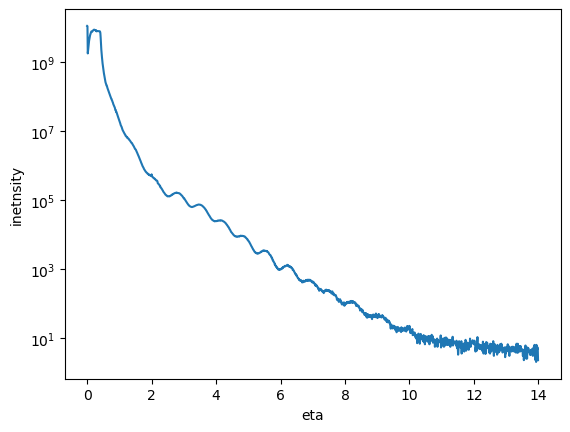

In [8]:
fname = '../data/s1_XRR_MAT.txt'

df=pandas.read_csv(fname, sep='\t', skiprows=12, names=columns, index_col=False)

measured_attenuation = [1, 6.85865, 47.0088, 318.6107, 2225.346, 15046.19, 97500.05]

factor = numpy.array(list(measured_attenuation[x] for x in df['att']))
plt.plot(df['delta'], factor * df['dir'] / df['time'])
plt.yscale('log')
plt.ylabel('inetnsity')
plt.xlabel('eta')
plt.show()

Final comment. This first example (`s1_XRR_MAT`) is a fairly simple film, probably a single layer film aith not much roughness.  As a result, the wiggles aren't that big, thus not that big of a devaition from the envelope whenplotted on log scale.

It is worth remaking the plot on linear scale to see that the first wiggle is actually an 80% deviation in raw intensity. I just mention that to stress that the tool we are building needs to understand that large deviations can occur, but that the correct choice still must be made for attenuator level.